In [1]:
import wandb

api = wandb.Api()
sweep = api.sweep("23f2001173-indian-institute-of-technology-madras/garbage_clf-src_scripts/x5rbvye6")

best_run = sweep.best_run()
print(f"Best run: {best_run.name}")
print(f"Best val_accuracy: {best_run.summary.get('val_accuracy')}")
print("\nBest hyperparameters:")
for key, value in best_run.config.items():
    if not key.startswith('_'):
        print(f"  {key}: {value}")

wandb: Sorting runs by -summary_metrics.val_accuracy


Best run: gallant-sweep-13
Best val_accuracy: 0.8203991055488586

Best hyperparameters:
  lr: 0.00015329703048163793
  stride: 1
  dropout: 0
  padding: same
  data_dir: data
  img_size: 128
  strategy: doubling
  num_dense: 512
  pooling_k: 2
  batch_size: 32
  input_size: 128
  max_epochs: 20
  num_layers: 5
  filter_size: 3
  in_channels: 3
  num_classes: 6
  num_workers: 4
  base_features: 32
  conv_activation: mish
  dense_activation: mish
  use_augmentation: True
  include_batchnorm: True


In [2]:
for k, v in best_run.summary.items():
    if not k.startswith('_'):
        print(f"{k}: {v}")

epoch: 19
train_accuracy: 0.9807375073432922
train_f1_class_cardboard: 0.9826388955116272
train_f1_class_glass: 0.9818689227104188
train_f1_class_metal: 0.9729729890823364
train_f1_class_paper: 0.9871645569801332
train_f1_class_plastic: 0.9841726422309875
train_f1_class_trash: 0.9543147087097168
train_loss_epoch: 0.07096266746520996
train_loss_step: 0.020310301333665848
train_precision_class_cardboard: 0.9895104765892028
train_precision_class_glass: 0.9859943985939026
train_precision_class_metal: 0.9696969985961914
train_precision_class_paper: 0.9837209582328796
train_precision_class_plastic: 0.982758641242981
train_precision_class_trash: 0.9494949579238892
train_recall_class_cardboard: 0.9758620858192444
train_recall_class_glass: 0.9777777791023254
train_recall_class_metal: 0.9762712121009828
train_recall_class_paper: 0.9906322956085204
train_recall_class_plastic: 0.9855907559394836
train_recall_class_trash: 0.9591836929321288
trainer/global_step: 1139
val_accuracy: 0.8203991055488586

In [3]:
import pandas as pd
import wandb

runs_df = pd.read_csv("wandb_export.csv")

corr = runs_df[
    ["val_accuracy", "lr", "dropout", "base_features", "num_dense",
     "dropout"]
].corr()["val_accuracy"]

print(corr)

val_accuracy     1.000000
lr              -0.329813
dropout         -0.239345
base_features    0.011430
num_dense       -0.099700
dropout         -0.239345
Name: val_accuracy, dtype: float64


In [4]:
_config = best_run.config
class Config:
    def __init__(self, cfg):
        for k, v in cfg.items():
            setattr(self, k, v)

config = Config(_config)

In [5]:
import sys
from pathlib import Path

# Get project root from notebook location
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
sys.path.insert(0, str(PROJECT_ROOT))
print(f"Added to path: {PROJECT_ROOT}")

Added to path: /home/nevrohelios/project/garbage_clf


In [7]:
import wandb
import os
import pytorch_lightning as pl
from pathlib import Path

from src.models.simple_cnn import SimpleCNN
from src.lightning.model import ModelLightning
from src.data.module import DataLoaderWrapper

dm = DataLoaderWrapper(
    data_dir=Path(os.path.join('..', config.data_dir)),
    img_size=config.img_size,
    mode='augment' if config.use_augmentation else None,
    batch_size=config.batch_size,
    num_workers=config.num_workers,
)

model = SimpleCNN(
    num_layers=config.num_layers,
    filter_size=config.filter_size,
    num_dense=config.num_dense,
    conv_activation=config.conv_activation,
    num_classes=config.num_classes,
    dense_activation=config.dense_activation,
    in_channels=config.in_channels,
    stride=config.stride,
    input_size=config.input_size,
    padding=config.padding,
    dropout=config.dropout if config.dropout > 0 else None,
    strategy=config.strategy,
    include_batchnorm=config.include_batchnorm,
    pooling_k=config.pooling_k,
    base_features=config.base_features,
)

pl_model = ModelLightning(
    model=model,
    lr=config.lr,
    idx_to_class=dm.idx_to_class,
)

In [8]:
# trainer = pl.Trainer(
#         max_epochs=config.max_epochs,
#         # logger=logger,
#         accelerator='auto',
#         devices='auto',
#         log_every_n_steps=10,
#     )

# trainer.fit(pl_model, datamodule=dm)

pl_model = ModelLightning.load_from_checkpoint(
    '/home/nevrohelios/project/garbage_clf/checkpoints/best_model_epoch=17_val_accuracy=0.8337.ckpt',
    model=model,
    idx_to_class=dm.idx_to_class
)

test_dataset = dm.val_dataloader()

In [9]:
trainer = pl.Trainer(
        max_epochs=config.max_epochs,
        # logger=logger,
        accelerator='auto',
        devices='auto',
        log_every_n_steps=10,
    )

trainer.test(model=pl_model, datamodule=dm)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/home/nevrohelios/miniconda3/envs/flsplit/lib/python3.10/site-packages/torch/__init__.py:1551: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allo

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃          Test metric           ┃          DataLoader 0          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_accuracy          │       0.2702702581882477       │
│    test_f1_class_cardboard     │      0.13636364042758942       │
│      test_f1_class_glass       │              0.0               │
│      test_f1_class_metal       │              0.0               │
│      test_f1_class_paper       │       0.4178082048892975       │
│     test_f1_class_plastic      │       0.1666666716337204       │
│      test_f1_class_trash       │              0.0               │
│           test_loss            │       7.603594779968262        │
│ test_precision_class_cardboard │              1.0               │
│   test_precision_class_glass   │              0.0               │
│   test_precision_class_metal   │              0.0               │
│   test_precision_class_paper   │      0.26406925916671753       │
│  test_precision_class_plastic  │       0.260869562625885        │
│   test_precision_class_trash   │              0.0               │
│  test_recall_class_cardboard   │       0.0731707289814949       │
│    test_recall_class_glass     │              0.0               │
│    test_recall_class_metal     │              0.0               │
│    test_recall_class_paper     │              1.0               │
│   test_recall_class_plastic    │      0.12244898080825806       │
│    test_recall_class_trash     │              0.0               │
└────────────────────────────────┴────────────────────────────────┘

[{'test_loss': 7.603594779968262,
  'test_accuracy': 0.2702702581882477,
  'test_f1_class_cardboard': 0.13636364042758942,
  'test_recall_class_cardboard': 0.0731707289814949,
  'test_precision_class_cardboard': 1.0,
  'test_f1_class_glass': 0.0,
  'test_recall_class_glass': 0.0,
  'test_precision_class_glass': 0.0,
  'test_f1_class_metal': 0.0,
  'test_recall_class_metal': 0.0,
  'test_precision_class_metal': 0.0,
  'test_f1_class_paper': 0.4178082048892975,
  'test_recall_class_paper': 1.0,
  'test_precision_class_paper': 0.26406925916671753,
  'test_f1_class_plastic': 0.1666666716337204,
  'test_recall_class_plastic': 0.12244898080825806,
  'test_precision_class_plastic': 0.260869562625885,
  'test_f1_class_trash': 0.0,
  'test_recall_class_trash': 0.0,
  'test_precision_class_trash': 0.0}]

In [76]:
import torchinfo

torchinfo.summary(pl_model, (32, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
ModelLightning                           [32, 6]                   --
├─SimpleCNN: 1-1                         [32, 6]                   --
│    └─Sequential: 2-1                   [32, 6]                   --
│    │    └─Sequential: 3-1              [32, 64, 64, 64]          4,992
│    │    └─Sequential: 3-2              [32, 128, 32, 32]         205,184
│    │    └─Sequential: 3-3              [32, 256, 16, 16]         819,968
│    │    └─Sequential: 3-4              [32, 512, 8, 8]           3,278,336
│    │    └─Sequential: 3-5              [32, 1024, 4, 4]          13,110,272
│    │    └─Flatten: 3-6                 [32, 16384]               --
│    │    └─Sequential: 3-7              [32, 64]                  1,048,640
│    │    └─Sequential: 3-8              [32, 6]                   390
Total params: 18,467,782
Trainable params: 18,467,782
Non-trainable params: 0
Total mult-adds (G): 109.99
Input size (M

In [69]:
import random
import torch
d = test_dataset.dataset

sample_idxs = random.sample(range(len(d)), 30)
samples = torch.stack([d[i][0] for i in sample_idxs])
labels = torch.tensor([d[i][1] for i in sample_idxs])
outputs = pl_model.forward(samples)
preds = torch.argmax(outputs, 1)

In [75]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

accuracy_score(labels, preds)

0.9666666666666667

<Figure size 2200x1000 with 0 Axes>

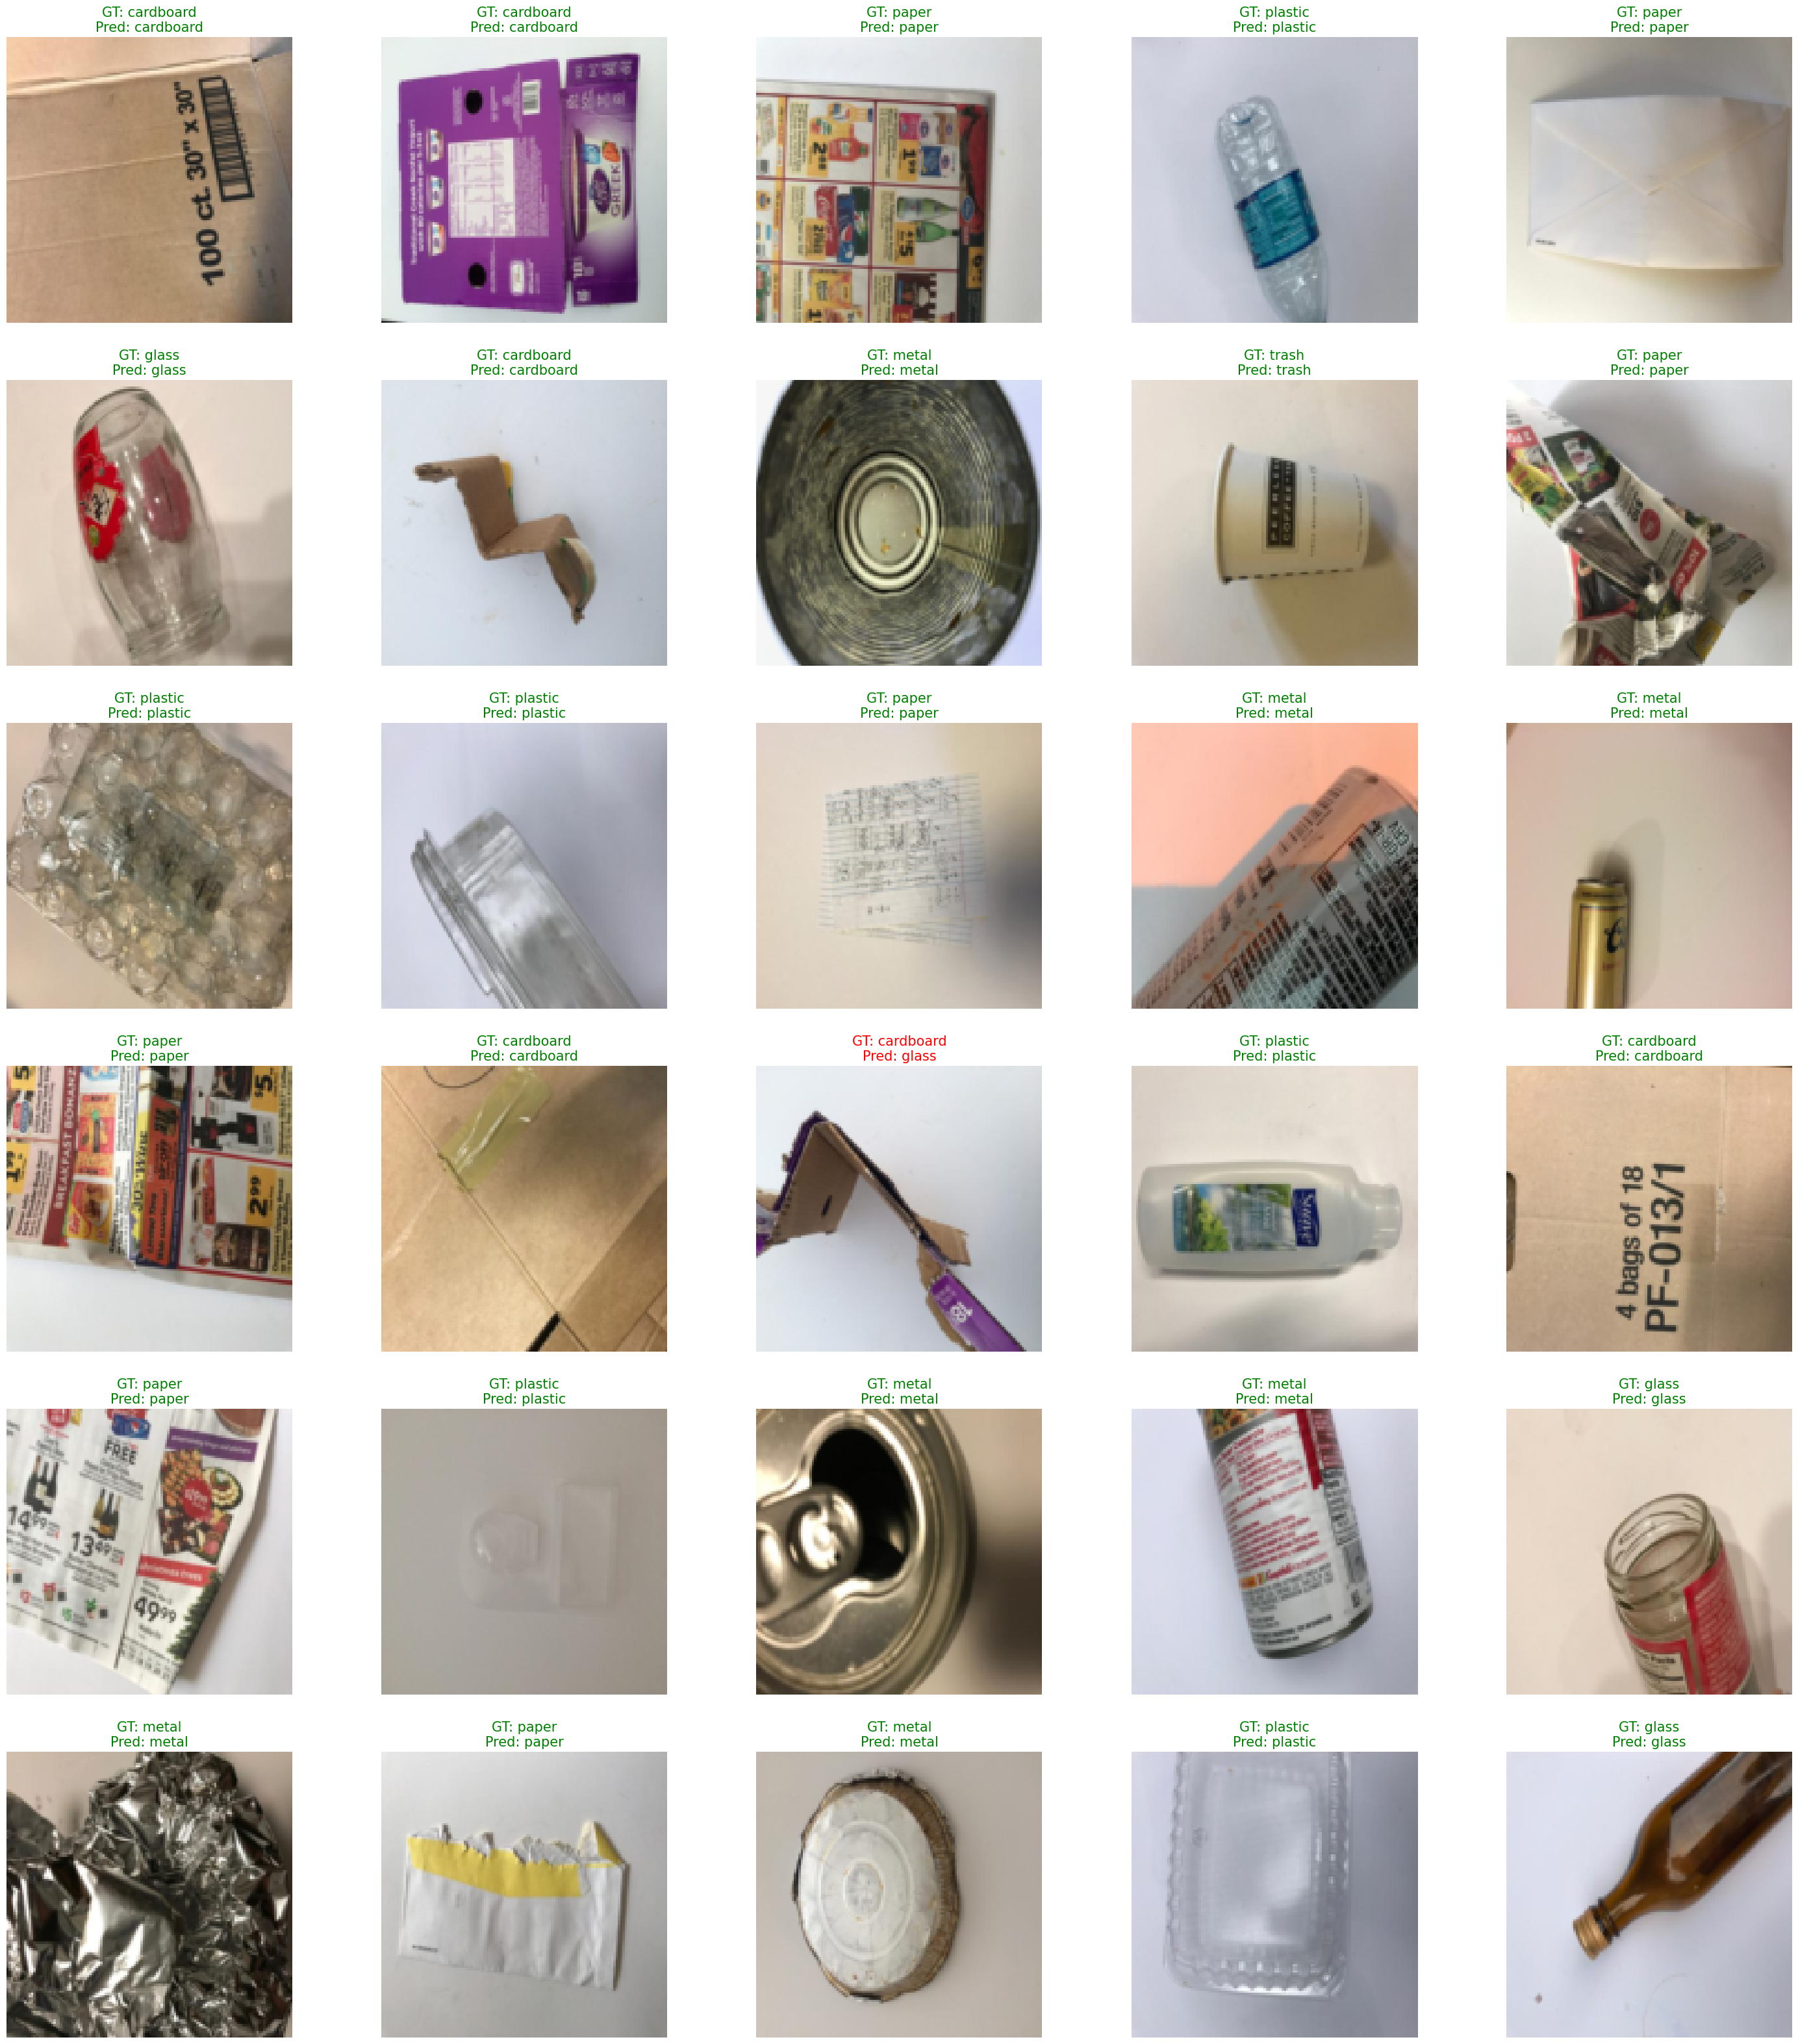

In [71]:
plt.figure(figsize=(22, 10))
fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(36, 40))
axs = axs.ravel()

for i, ax in enumerate(axs):
    img = samples[i]

    # CHW → HWC
    if img.shape[0] == 3:
        img = img.permute(1, 2, 0)

    img = img.numpy()

    ax.imshow(img,)
    ax.axis("off")

    gt = dm.idx_to_class[labels[i].item()]
    pred = dm.idx_to_class[preds[i].item()]

    color = "green" if gt == pred else "red"

    ax.set_title(
        f"GT: {gt}\nPred: {pred}",
        fontsize=15,
        color=color
    )

# plt.tight_layout()
plt.show()

In [73]:
fig.savefig("test_predictions_grid.png", dpi=300, bbox_inches="tight")